In [303]:
pip install mpl


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


<a id='intro'></a>
## Intro
WeRateDogs is a Twitter account known for posting and rating pictures of dogs. The ratings are often humorous, with numerators sometimes exceeding denominators. This analysis focuses on cleaning and analyzing the WeRateDogs Twitter archive up to August 1, 2017. The provided dataset includes tweet information and dog details such as names, ratings, and stages (doggo, floofer, pupper, or puppo). However, some data is missing from the Udacity dataset, so additional information will be gathered using the Twitter API.

The data wrangling will concentrate on original tweets from WeRateDogs that include both ratings and images. The final analysis will address the following questions:

What are the trends in WeRateDogs's posting frequency by month? How do interactions with WeRateDogs's posts vary monthly? What are the most popular dog breeds in terms of post frequency, user interactions, and ratings? Is there a correlation between WeRateDogs's ratings and user interactions?

In [304]:
pip install mpl


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [305]:
pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [306]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [307]:
pip install requests


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: requests in c:\users\nouma\appdata\local\programs\python\python312\lib\site-packages (2.32.3)




[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [308]:
pip install tweepy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [309]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import mpl.pyplot as plt
import seaborn as sb
from scipy.stats import pearsonr
%mpl inline
pd.set_option('display.max_colwidth', None)

<a id='gather'></a>
## Gather

First, I downloaded the Twitter archive from Udacity and will read it into a dataframe.


In [310]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
with open(url.split('/')[-1], mode='wb') as file:
    file.write(r.content)

In [311]:
predictions = pd.read_csv('image-predictions.tsv', sep='\t')

In [312]:


df_list = []
with open('tweet_json.txt', mode='r', encoding='utf-8') as file:
    lines = file.readlines()
    # Read tweet JSON data line by line
    for line in lines:
        try:
            data = json.loads(line)
            tweet_id = data.get('id', 'ID not found')
            retweet_count = data.get('retweet_count', 0)  # Default to 0 if key is not found
            favorite_count = data.get('favorite_count', 0)  # Default to 0 if key is not found
            df_list.append({
                'tweet_id': tweet_id,
                'retweet_count': retweet_count,
                'favorite_count': favorite_count
            })
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
        except KeyError as e:
            print(f"Key error: {e}")

# Create DataFrame from list of dictionaries
tweet_data = pd.DataFrame(df_list, columns=['tweet_id', 'retweet_count', 'favorite_count'])

# Display the DataFrame
print(tweet_data.head())


             tweet_id  retweet_count  favorite_count
0  892420643555336193              0               0
1  892177421306343426              0               0
2  891815181378084864              0               0
3  891689557279858688              0               0
4  891327558926688256              0               0


In [313]:
df_list = []
with open('tweet_json.txt', mode='r', encoding='utf-8') as file:
    lines = file.readlines()
    # Read tweet JSON data line by line
    for line in lines:
        try:
            data = json.loads(line)
            tweet_id = data.get('id', 'ID not found')
            retweet_count = data.get('retweet_count', 0)  # Default to 0 if key is not found
            favorite_count = data.get('favorite_count', 0)  # Default to 0 if key is not found
            df_list.append({
                'tweet_id': tweet_id,
                'retweet_count': retweet_count,
                'favorite_count': favorite_count
            })
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
        except KeyError as e:
            print(f"Key error: {e}")

# Create DataFrame from list of dictionaries
tweet_data = pd.DataFrame(df_list, columns=['tweet_id', 'retweet_count', 'favorite_count'])

# Display the DataFrame
print(tweet_data.head())


             tweet_id  retweet_count  favorite_count
0  892420643555336193              0               0
1  892177421306343426              0               0
2  891815181378084864              0               0
3  891689557279858688              0               0
4  891327558926688256              0               0


<a id='assess'></a>
## Assess

Now that the data is gathered, I will assess it to see what cleaning I will have to do. First I see the data

In [314]:
predictions

tweet_id                                          jpg_url  \
0     666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1     666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2     666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3     666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4     666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   
...                  ...                                              ...   
2070  891327558926688256  https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg   
2071  891689557279858688  https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg   
2072  891815181378084864  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg   
2073  892177421306343426  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg   
2074  892420643555336193  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg   

      img_num                      p1   p1_conf  p1_dog                  p2  \
0           1  Welsh_springer_spaniel  0.465074    True              collie   
1           1                 redbone  0.506826    True  miniature_pinscher   
2           1         German_shepherd  0.596461    True            malinois   
3           1     Rhodesian_ridgeback  0.408143    True             redbone   
4           1      miniature_pinscher  0.560311    True          Rottweiler   
...       ...                     ...       ...     ...                 ...   
2070        2                  basset  0.555712    True    English_springer   
2071        1             paper_towel  0.170278   False  Labrador_retriever   
2072        1               Chihuahua  0.716012    True            malamute   
2073        1               Chihuahua  0.323581    True            Pekinese   
2074        1                  orange  0.097049   False               bagel   

       p2_conf  p2_dog                           p3   p3_conf  p3_dog  
0     0.156665    True            Shetland_sheepdog  0.061428    True  
1     0.074192    True          Rhodesian_ridgeback  0.072010    True  
2     0.138584    True                   bloodhound  0.116197    True  
3     0.360687    True           miniature_pinscher  0.222752    True  
4     0.243682    True                     Doberman  0.154629    True  
...        ...     ...                          ...       ...     ...  
2070  0.225770    True  German_short-haired_pointer  0.175219    True  
2071  0.168086    True                      spatula  0.040836   False  
2072  0.078253    True                       kelpie  0.031379    True  
2073  0.090647    True                     papillon  0.068957    True  
2074  0.085851   False                       banana  0.076110   False  

[2075 rows x 12 columns]

In [315]:
tweet_data = pd.read_csv('tweet_json_clean.csv')

failed_tweet = []

with open('tweet_json.txt', mode='w', encoding='utf-8') as file:
    for index, row in tweet_data.iterrows():
        tweet_id = row['tweet_id']
        try:
            # Simulate or process tweet data (adjust based on your actual data structure)
            tweet = {
                'id': tweet_id,
                'created_at': row.get('created_at', ''),  # Replace with actual column name
                'full_text': row.get('full_text', '')
                # Add more fields as necessary
            }
            tweet_json = json.dumps(tweet)
            file.write(tweet_json + '\n')
        except Exception as e:
            print(f"Failed to process tweet {tweet_id}: {str(e)}")
            failed_tweet.append(tweet_id)

In [316]:
tweet_data

tweet_id  retweet_count  favorite_count  retweeted  \
0     892420643555336193           8853           39467      False   
1     892177421306343426           6514           33819      False   
2     891815181378084864           4328           25461      False   
3     891689557279858688           8964           42908      False   
4     891327558926688256           9774           41048      False   
...                  ...            ...             ...        ...   
2349  666049248165822465             41             111      False   
2350  666044226329800704            147             311      False   
2351  666033412701032449             47             128      False   
2352  666029285002620928             48             132      False   
2353  666020888022790149            532            2535      False   

     display_text_range  
0               [0, 85]  
1              [0, 138]  
2              [0, 121]  
3               [0, 79]  
4              [0, 138]  
...                 ...  
2349           [0, 120]  
2350           [0, 137]  
2351           [0, 130]  
2352           [0, 139]  
2353           [0, 131]  

[2354 rows x 5 columns]

In [317]:
archive

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892420643555336193                    NaN                  NaN   
1     892177421306343426                    NaN                  NaN   
2     891815181378084864                    NaN                  NaN   
3     891689557279858688                    NaN                  NaN   
4     891327558926688256                    NaN                  NaN   
...                  ...                    ...                  ...   
2351  666049248165822465                    NaN                  NaN   
2352  666044226329800704                    NaN                  NaN   
2353  666033412701032449                    NaN                  NaN   
2354  666029285002620928                    NaN                  NaN   
2355  666020888022790149                    NaN                  NaN   

                      timestamp  \
0     2017-08-01 16:23:56 +0000   
1     2017-08-01 00:17:27 +0000   
2     2017-07-31 00:18:03 +0000   
3     2017-07-30 15:58:51 +0000   
4     2017-07-29 16:00:24 +0000   
...                         ...   
2351  2015-11-16 00:24:50 +0000   
2352  2015-11-16 00:04:52 +0000   
2353  2015-11-15 23:21:54 +0000   
2354  2015-11-15 23:05:30 +0000   
2355  2015-11-15 22:32:08 +0000   

                                                                                  source  \
0     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
3     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
4     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
...                                                                                  ...   
2351  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2352  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2353  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2354  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2355  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                                                    text  \
0                                                          This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU   
1     This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV   
2                      This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB   
3                                                                This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ   
4     This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f   
...                                                                                                                                                                  ...   
2351                                            Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq   
2352                           This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx   
2353                                  Here is a very happy pup. Big fan of we

In [318]:
archive = pd.read_csv('twitter-archive-enhanced.csv')

In [319]:
# image predictions URL provided by Udacity
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
with open(url.split('/')[-1], mode='wb') as file:
    file.write(r.content)

Observations:

archive DataFrame:

The dataframe is not in a tidy format due to the way dog stages are represented. Instead of having separate columns for each stage (e.g., doggo, floofer, pupper, puppo), there should be a single column that indicates the dog's stage.
Some names in the name column appear to be incorrect, such as "a," which is unlikely to be a valid dog name.
predictions DataFrame:

The dataframe is not tidy because predictions are spread across multiple columns (e.g., p1, p2, p3). Instead, there should be one column to denote the prediction number, with additional columns for the actual prediction, confidence level, and type of dog breed.
Predictions in columns p1, p2, and p3 have inconsistent capitalization.
tweet_data DataFrame:

Some tweets are deleted, resulting in missing retweet and favorite counts. Unfortunately, this missing data cannot be recovered.
Plan for Tidy Data:

archive DataFrame:

Combine the separate dog stage columns into a single column to represent the dog's stage.
Clean the name column to address incorrect or placeholder names.
predictions DataFrame:

Restructure the dataframe so that there is one column for prediction number and additional columns for the prediction itself, confidence score, and breed type.
Standardize the capitalization across the prediction columns.
tweet_data DataFrame:

Acknowledge that missing retweet and favorite counts due to deleted tweets cannot be retrieved, but ensure the dataframe is clean and well-structured within these constraints.
Next Steps:

Check for duplicate rows or tweet_ids in the archive dataframe programmatically to identify and handle any redundancy.


In [320]:
sum(archive.duplicated())

0

I also use info to check the dataframe for any potential issues.

In [321]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        1611 non-null   object 
 13  doggo                       97 no

a couple of data types that should be changed. `timestamp` should be have the `datetime` data type, and the dog stage should be a categorical data type.

I also see that `archive` has retweets, which should not be included because I only care about original content from WeRateDogs. I will check to see if the values in `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` are all in the same rows.

In [322]:
len(archive[
    archive['retweeted_status_id'].notnull()
    & archive['retweeted_status_user_id'].notnull()
    & archive['retweeted_status_timestamp'].notnull()
])

181

In [323]:
archive['expanded_urls'].sample(5)

1825                                                                                                                             https://twitter.com/dog_rates/status/676470639084101634/photo/1
309     https://www.gofundme.com/lolas-life-saving-surgery-funds,https://twitter.com/dog_rates/status/835264098648616962/photo/1,https://twitter.com/dog_rates/status/835264098648616962/photo/1
112                                                                                                                              https://twitter.com/dog_rates/status/870804317367881728/photo/1
1606                                                                                                                             https://twitter.com/dog_rates/status/685667379192414208/photo/1
1052                                                             https://twitter.com/dog_rates/status/742528092657332225/photo/1,https://twitter.com/dog_rates/status/742528092657332225/photo/1
Name: expanded_urls, dtype: object

In [324]:
archive.describe()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
count  2.356000e+03           7.800000e+01         7.800000e+01   
mean   7.427716e+17           7.455079e+17         2.014171e+16   
std    6.856705e+16           7.582492e+16         1.252797e+17   
min    6.660209e+17           6.658147e+17         1.185634e+07   
25%    6.783989e+17           6.757419e+17         3.086374e+08   
50%    7.196279e+17           7.038708e+17         4.196984e+09   
75%    7.993373e+17           8.257804e+17         4.196984e+09   
max    8.924206e+17           8.862664e+17         8.405479e+17   

       retweeted_status_id  retweeted_status_user_id  rating_numerator  \
count         1.810000e+02              1.810000e+02       2356.000000   
mean          7.720400e+17              1.241698e+16         13.126486   
std           6.236928e+16              9.599254e+16         45.876648   
min           6.661041e+17              7.832140e+05          0.000000   
25%           7.186315e+17              4.196984e+09         10.000000   
50%           7.804657e+17              4.196984e+09         11.000000   
75%           8.203146e+17              4.196984e+09         12.000000   
max           8.874740e+17              7.874618e+17       1776.000000   

       rating_denominator  
count         2356.000000  
mean            10.455433  
std              6.745237  
min              0.000000  
25%             10.000000  
50%             10.000000  
75%             10.000000  
max            170.000000

In [325]:
archive['text'].str.extract('(\d+)/(\d+)').astype(int).describe()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Nouma\AppData\Local\Temp\ipykernel_12216\3622599330.py:1: SyntaxWarning: invalid escape sequence '\d'
  archive['text'].str.extract('(\d+)/(\d+)').astype(int).describe()


0            1
count  2356.000000  2356.000000
mean     13.126486    10.455433
std      45.876648     6.745237
min       0.000000     0.000000
25%      10.000000    10.000000
50%      11.000000    10.000000
75%      12.000000    10.000000
max    1776.000000   170.000000

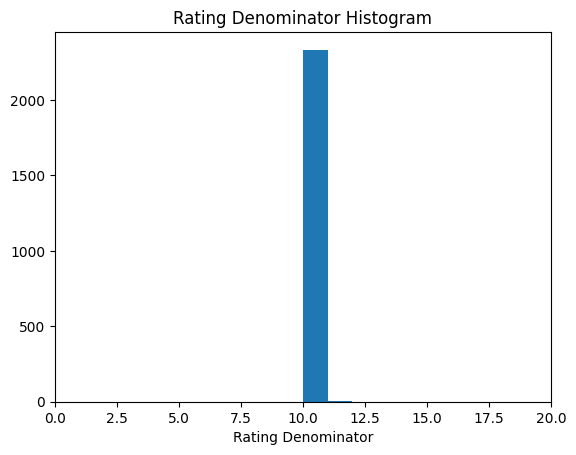

In [326]:
bins = np.arange(0, archive['rating_denominator'].max()+1, 1)
plt.hist(data=archive, x='rating_denominator', bins=bins)
plt.title('Rating Denominator Histogram')
plt.xlabel('Rating Denominator')
plt.xlim(0, 20);

In [327]:
archive.query('rating_denominator != 10')['text']

313                                                                            @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
342                                                                                                                                      @docmisterio account started on 11/15/15
433                                                                           The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
516     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
784                                  RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
902                                                                                                Why does th

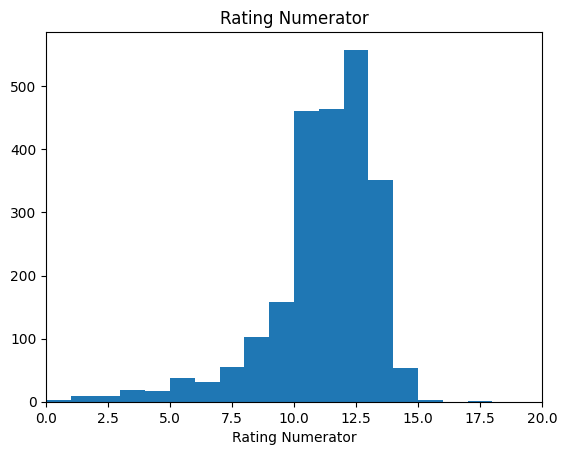

In [328]:
bins = np.arange(0, archive['rating_numerator'].max()+1, 1)
plt.hist(data=archive, x='rating_numerator', bins=bins)
plt.title('Rating Numerator')
plt.xlabel('Rating Numerator')
plt.xlim(0, 20);

In [329]:
archive.query('rating_numerator >= 15')['text']

55                                                                                    @roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s
188                                                                                        @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
189                                         @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10
285                                                                               RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI
290                                                                                                                                                            @markhoppus 182/10
291                                                                                                           

In [330]:
 with pd.option_context('display.max_rows', None):   
    print(archive.query('rating_numerator < 5')['text'])

315                                When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
605     RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…
765     This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M
883     This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP
912     Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL19Wsl
1004      Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R
1016                         PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 m

In [331]:
archive['name'].value_counts()

name
a             55
Charlie       12
Oliver        11
Cooper        11
Lucy          11
              ..
Aqua           1
Chase          1
Meatball       1
Rorie          1
Christoper     1
Name: count, Length: 956, dtype: int64

In [332]:
archive_cleaned = archive.dropna(subset=['name'])

# Use regex to find all lowercase names
lowercase_names = archive_cleaned[archive_cleaned['name'].str.contains(r'^[^A-Z].*$', na=False)]['name'].value_counts()

print(lowercase_names)

name
a               55
the              8
an               7
very             5
just             4
quite            4
one              4
getting          2
actually         2
mad              2
not              2
old              1
life             1
officially       1
light            1
by               1
infuriating      1
such             1
all              1
unacceptable     1
this             1
his              1
my               1
incredibly       1
space            1
Name: count, dtype: int64


In [333]:
archive_cleaned = archive.dropna(subset=['name'])

# Use regex to find all lowercase names
lowercase_names = archive_cleaned[archive_cleaned['name'].str.contains(r'^[^A-Z].*$', na=False)]['text']

# Print lowercase names and corresponding text
with pd.option_context('display.max_rows', None):
    print(lowercase_names)

22                                    I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba
56             Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
118                           RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…
169                   We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9
193     Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x
335                                                               There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10  

In [334]:
def compare_stage(stage, regex):
    '''
    INPUT:
    stage (str)
    regex (str)
    OUTPUT:
    None
    
    Print
    '''
    
    print('Original value counts for {}:\n'.format(stage))
    print(archive[stage].value_counts())
    print('\n')
    print('New value counts:\n')
    stage_regex = archive['text'].str.extract(regex)[0]
    print(stage_regex.value_counts())
    print('\n')
    print('New total: {}'.format(stage_regex.count()))

In [335]:
compare_stage('doggo', '([Dd]+[Oo]+[Gg]+[Oo]+[Ss]*)')

Original value counts for doggo:

doggo
doggo    97
Name: count, dtype: int64


New value counts:

0
doggo     87
doggos    10
Doggo      9
DOGGO      1
Name: count, dtype: int64


New total: 107


In [336]:
compare_stage('floofer', '([Ff]+[Ll]+[Oo]+[Ff]+[Ee]+[Rr]+[Ss]*)')

Original value counts for floofer:

floofer
floofer    10
Name: count, dtype: int64


New value counts:

0
Floofer    6
floofer    4
Name: count, dtype: int64


New total: 10


In [337]:
compare_stage('pupper', '([Pp]+[Uu]+[Pp]+[Ee]+[Rr]+[Ss]*)')

Original value counts for pupper:

pupper
pupper    257
Name: count, dtype: int64


New value counts:

0
pupper     247
puppers     23
Pupper       8
PUPPER       5
Name: count, dtype: int64


New total: 283


In [338]:
compare_stage('puppo', '([Pp]+[Uu]+[Pp]+[Oo]+[Ss]*)')

Original value counts for puppo:

puppo
puppo    30
Name: count, dtype: int64


New value counts:

0
puppo     35
puppos     2
Puppo      1
Name: count, dtype: int64


New total: 38


In [339]:
sum(predictions.duplicated())

0

In [340]:
sum(predictions.duplicated('jpg_url'))

66

In [341]:
duplicated_jpg_url = predictions[predictions.duplicated('jpg_url')]['tweet_id']

In [342]:
archive.query('tweet_id in @duplicated_jpg_url')

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
19   888202515573088257                    NaN                  NaN   
36   885311592912609280                    NaN                  NaN   
95   873697596434513921                    NaN                  NaN   
155  861769973181624320                    NaN                  NaN   
211  851953902622658560                    NaN                  NaN   
..                  ...                    ...                  ...   
890  759566828574212096                    NaN                  NaN   
895  759159934323924993                    NaN                  NaN   
908  757729163776290825                    NaN                  NaN   
926  754874841593970688                    NaN                  NaN   
949  752309394570878976                    NaN                  NaN   

                     timestamp  \
19   2017-07-21 01:02:36 +0000   
36   2017-07-13 01:35:06 +0000   
95   2017-06-11 00:25:14 +0000   
155  2017-05-09 02:29:07 +0000   
211  2017-04-12 00:23:33 +0000   
..                         ...   
890  2016-07-31 01:50:18 +0000   
895  2016-07-29 22:53:27 +0000   
908  2016-07-26 00:08:05 +0000   
926  2016-07-18 03:06:01 +0000   
949  2016-07-11 01:11:51 +0000   

                                                                                 source  \
19   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
36   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
95   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
155  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
211  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
..                                                                                  ...   
890  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
895  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
908  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
926  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
949  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                           text  \
19   RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX   
36        RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5   
95    RT @dog_rates: This is Walter. He won't start hydrotherapy without his favorite floatie. 14/10 keep it pup Walter https://t.co/r28jFx9uyF   
155                RT @dog_rates: "Good afternoon class today we're going to learn what makes a good boy so good" 13/10 https://t.co/f1h2Fsalv9   
211                         RT @dog_rates: This is Astrid. She's a guide doggo in training. 13/10 would follow anywhere https://t.co/xo7FZFIAao   
..                                                                                                                                          ...   
890      RT @dog_rates: This... is a Tyrannosaurus rex. We only rate dogs. Please only send in dogs. Thank you ...10/10 https://t.co/zxw8d5g94P   
895                                                                         RT @dog_rates: AT DAWN...\nWE RIDE\n\n11/10 https://t.co/QnfO7HEQGA   
908                                                     RT @dog_rates: This is Chompsky. He lives up to his name. 11/10 https://t.co/Xl37lQEWd0   
926                                                           RT @dog_rates: This is Rubio. He has too much skin. 11/10 https://t.co/NLOHmlENag   
949                                        

In [343]:
archive.query('tweet_id in @duplicated_jpg_url')['retweeted_status_id'].count()

np.int64(66)

In [344]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [345]:
predictions.describe()

tweet_id      img_num      p1_conf       p2_conf       p3_conf
count  2.075000e+03  2075.000000  2075.000000  2.075000e+03  2.075000e+03
mean   7.384514e+17     1.203855     0.594548  1.345886e-01  6.032417e-02
std    6.785203e+16     0.561875     0.271174  1.006657e-01  5.090593e-02
min    6.660209e+17     1.000000     0.044333  1.011300e-08  1.740170e-10
25%    6.764835e+17     1.000000     0.364412  5.388625e-02  1.622240e-02
50%    7.119988e+17     1.000000     0.588230  1.181810e-01  4.944380e-02
75%    7.932034e+17     1.000000     0.843855  1.955655e-01  9.180755e-02
max    8.924206e+17     4.000000     1.000000  4.880140e-01  2.734190e-01

In [346]:
predictions.query('p1_conf+p2_conf+p3_conf > 1')

tweet_id                                          jpg_url  \
106  667866724293877760  https://pbs.twimg.com/media/CUS9PlUWwAANeAD.jpg   

     img_num             p1  p1_conf  p1_dog          p2       p2_conf  \
106        1  jigsaw_puzzle      1.0   False  prayer_rug  1.011300e-08   

     p2_dog       p3       p3_conf  p3_dog  
106   False  doormat  1.740170e-10   False

In [347]:
predictions.query('p1_dog == False & p2_dog == False & p3_dog == False')

tweet_id  \
6     666051853826850816   
17    666104133288665088   
18    666268910803644416   
21    666293911632134144   
25    666362758909284353   
...                  ...   
2021  880935762899988482   
2022  881268444196462592   
2046  886680336477933568   
2052  887517139158093824   
2074  892420643555336193   

                                                                                      jpg_url  \
6                                             https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg   
17                                            https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg   
18                                            https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg   
21                                            https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg   
25                                            https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg   
...                                                                                       ...   
2021                                          https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg   
2022                                          https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg   
2046                                          https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg   
2052  https://pbs.twimg.com/ext_tw_video_thumb/887517108413886465/pu/img/WanJKwssZj4VJvL9.jpg   
2074                                          https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg   

      img_num                p1   p1_conf  p1_dog               p2   p2_conf  \
6           1        box_turtle  0.933012   False       mud_turtle  0.045885   
17          1               hen  0.965932   False             cock  0.033919   
18          1  desktop_computer  0.086502   False             desk  0.085547   
21          1  three-toed_sloth  0.914671   False            otter  0.015250   
25          1        guinea_pig  0.996496   False            skunk  0.002402   
...       ...               ...       ...     ...              ...       ...   
2021        1       street_sign  0.251801   False         umbrella  0.115123   
2022        1            tusker  0.473303   False  Indian_elephant  0.245646   
2046        1       convertible  0.738995   False       sports_car  0.139952   
2052        1         limousine  0.130432   False        tow_truck  0.029175   
2074        1            orange  0.097049   False            bagel  0.085851   

      p2_dog              p3   p3_conf  p3_dog  
6      False        terrapin  0.017885   False  
17     False       partridge  0.000052   False  
18     False        bookcase  0.079480   False  
21     False  great_grey_owl  0.013207   False  
25     False         hamster  0.000461   False  
...      ...             ...       ...     ...  
2021   False   traffic_light  0.069534   False  
2022   False            ibex  0.055661   False  
2046   False       car_wheel  0.044173   False  
2052   False   shopping_cart  0.026321   False  
2074   False          banana  0.076110   False  

[324 rows x 12 columns]

In [348]:
predictions[predictions['p1'].str.contains(' ')]

Empty DataFrame
Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
Index: []

In [349]:
predictions[predictions['p2'].str.contains(' ')]

Empty DataFrame
Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
Index: []

In [350]:
predictions[predictions['p3'].str.contains(' ')]

Empty DataFrame
Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
Index: []

In [351]:
sum(tweet_data.duplicated())

0

In [352]:
sum(tweet_data.duplicated('tweet_id'))

0

In [353]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2354 non-null   int64 
 1   retweet_count       2354 non-null   int64 
 2   favorite_count      2354 non-null   int64 
 3   retweeted           2354 non-null   bool  
 4   display_text_range  2354 non-null   object
dtypes: bool(1), int64(3), object(1)
memory usage: 76.0+ KB


In [354]:
tweet_data.describe()

tweet_id  retweet_count  favorite_count
count  2.354000e+03    2354.000000     2354.000000
mean   7.426978e+17    3164.797366     8080.968564
std    6.852812e+16    5284.770364    11814.771334
min    6.660209e+17       0.000000        0.000000
25%    6.783975e+17     624.500000     1415.000000
50%    7.194596e+17    1473.500000     3603.500000
75%    7.993058e+17    3652.000000    10122.250000
max    8.924206e+17   79515.000000   132810.000000

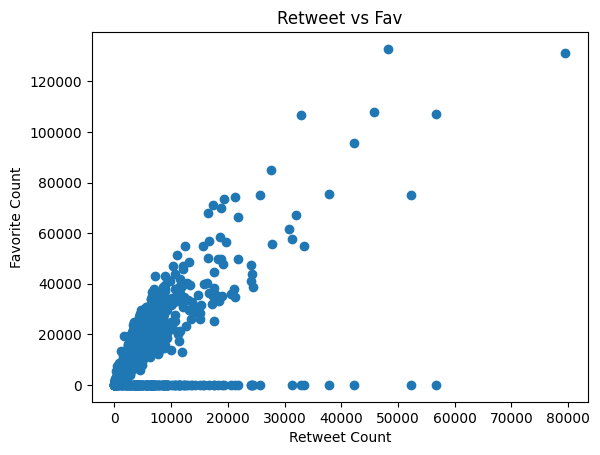

In [355]:
plt.scatter(data=tweet_data, x='retweet_count', y='favorite_count')
plt.title('Retweet vs Fav')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count');

In [356]:
tweet_data.query('retweet_count > favorite_count')

tweet_id  retweet_count  favorite_count  retweeted  \
31    886054160059072513            108               0      False   
35    885311592912609280          19297               0      False   
67    879130579576475649           7181               0      False   
72    878404777348136964           1349               0      False   
73    878316110768087041           6965               0      False   
...                  ...            ...             ...        ...   
1021  746521445350707200           1110               0      False   
1041  743835915802583040           2387               0      False   
1240  711998809858043904            138               0      False   
2257  667550904950915073             37               0      False   
2258  667550882905632768             34               0      False   

     display_text_range  
31              [0, 50]  
35             [0, 133]  
67             [0, 140]  
72             [0, 140]  
73             [0, 140]  
...                 ...  
1021           [0, 140]  
1041           [0, 140]  
1240            [0, 97]  
2257           [0, 123]  
2258           [0, 104]  

[179 rows x 5 columns]

In [357]:
tweet_data.query('retweet_count > favorite_count & favorite_count != 0')

Empty DataFrame
Columns: [tweet_id, retweet_count, favorite_count, retweeted, display_text_range]
Index: []

In [358]:
zero_favorite_count = tweet_data.query('favorite_count == 0')['tweet_id']

In [359]:
archive.query('tweet_id in @zero_favorite_count')

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
32    886054160059072513                    NaN                  NaN   
36    885311592912609280                    NaN                  NaN   
68    879130579576475649                    NaN                  NaN   
73    878404777348136964                    NaN                  NaN   
74    878316110768087041                    NaN                  NaN   
...                  ...                    ...                  ...   
1023  746521445350707200                    NaN                  NaN   
1043  743835915802583040                    NaN                  NaN   
1242  711998809858043904                    NaN                  NaN   
2259  667550904950915073                    NaN                  NaN   
2260  667550882905632768                    NaN                  NaN   

                      timestamp  \
32    2017-07-15 02:45:48 +0000   
36    2017-07-13 01:35:06 +0000   
68    2017-06-26 00:13:58 +0000   
73    2017-06-24 00:09:53 +0000   
74    2017-06-23 18:17:33 +0000   
...                         ...   
1023  2016-06-25 01:52:36 +0000   
1043  2016-06-17 16:01:16 +0000   
1242  2016-03-21 19:31:59 +0000   
2259  2015-11-20 03:51:52 +0000   
2260  2015-11-20 03:51:47 +0000   

                                                                                  source  \
32    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
36    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
68    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
73    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
74    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
...                                                                                  ...   
1023  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1043  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1242  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2259                  <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>   
2260                  <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>   

                                                                                                                                                text  \
32                                                                                                RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo   
36             RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5   
68      RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…   
73    RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…   
74      RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…   
...                                                                                                                                              ...   
1023    RT @dog_rates: This is Shaggy. He knows exactly how to solve the puzzle but can't talk. All he wants to do is help. 10/10 great guy https:/…   
1043    RT @dog_rates: Extremely intelligent dog here. Has learned to walk like human. Even has his own dog. Very impressive 10/10 https://t.co/0Dv…   
1242                                               RT @twitter: @dog_rates Awesome Tweet! 12/10. Would Retweet. #LoveTwitter https://t.co/j6FQGhxYuN   
2259                     RT @dogratingrating: Exceptional talent. Original humor. Cutting edge, Nova Scot

a summary of the assessments made in the Assess section, highlighting both tidiness and quality issues in the archive, predictions, and tweet_data dataframes:

Tidiness Issues
archive DataFrame:

Stage Columns: The columns for dog stages (doggo, floofer, pupper, puppo) are not tidy. They should be consolidated into a single column to indicate the dog's stage.
predictions DataFrame:

Prediction Columns: The columns related to prediction 1, prediction 2, and prediction 3 are not tidy. The data should be reshaped so that there is one column for the prediction number, along with additional columns for prediction details.
Other:

Observational Units: Each dataframe should represent a distinct observational unit. Currently, the data is not tidy because it does not separate tweet data, dog data, and image predictions into individual dataframes.
Quality Issues
archive DataFrame:

Categorical Data Type: After tidying, the stage columns should be categorized appropriately.
Datetime Data Type: The timestamp column should be converted to the datetime data type for accurate time-based analysis.
Content Authenticity: The dataframe includes retweets and posts without images, affecting the purity of the dataset.
Ratings Extraction: Ratings should include decimals and be of type float, as some ratings are incorrectly extracted.
Name Errors: Many dog names are either "None" or incorrectly formatted (lowercase), requiring cleaning.
Stage Variations: Variations in stage names have not been correctly extracted, affecting data consistency.
predictions DataFrame:

Prediction Number Data Type: The prediction number should have an int data type after tidying.
Capitalization Inconsistency: The values in columns p1, p2, and p3 have inconsistent capitalization, which should be standardized.
Non-Dog Predictions: Some images do not have dog-related predictions, which should be addressed.
Duplicate URLs: There are duplicated jpg_url entries, often related to retweets.
Confidence Error: One row has a total confidence value greater than 1, which is a data error.
tweet_data DataFrame:

Missing Data: Some tweets have missing retweet_count or favorite_count data, which cannot be retrieved.
Zero Favorite Counts: Many rows have 0 as the favorite_count, indicating retweets or posts without interactions.
Next Steps for Data Cleaning
Transform and Reshape Data:

Consolidate stage columns in the archive dataframe.
Reshape prediction-related columns in the predictions dataframe.
Fix Data Quality Issues:

Convert data types as needed (e.g., categorical, datetime, float, int).
Clean and standardize names and stage variations.
Address inconsistencies in capitalization and prediction data.
Remove or handle duplicates and incorrect confidence values.
Create Separate Dataframes:

Separate the data into distinct dataframes for tweet data, dog data, and image predictions, ensuring each dataframe represents a single observational unit.
By addressing these tidiness and quality issues, i will enhance the usability and accuracy of your datasets, making them more suitable for analysis and insights.

<a id='clean'></a>
## Clean

To begin the cleaning process, I will first make copies of each dataframe. Then, for each step of cleaning, I will define the process, write the code, and then test to see if the changes were made.

In [360]:
archive.query('tweet_id in @zero_favorite_count')['retweeted_status_id'].count()

np.int64(179)

In [361]:
archive_clean = archive.copy()
predictions_clean = predictions.copy()
tweet_data_clean = tweet_data.copy()

In the first section of cleaning, I will narrow down `archive_clean` and `predictions_clean` to only original content with images of dogs.

#### 1 Define

Remove retweets by dropping rows in `archive_clean` that have values in `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp`, and then drop those three columns.

#### Code

In [362]:
# remove retweets
archive_clean = archive_clean[archive_clean['retweeted_status_id'].isnull()]

In [363]:
# drop columns related to retweets that should be null now
archive_clean.drop(
    ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'],
    axis=1,
    inplace=True
)

TEST

In [364]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   1495 non-null   object 
 10  doggo                  87 non-null     object 
 11  floofer                10 non-null     object 
 12  pupper                 234 non-null    object 
 13  puppo                  25 non-null     object 
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ KB


#### 2 Define

Query for rows in `predictions_clean` with `tweet_id` that are also in `archive_clean` to remove retweets. This should also remove the duplicated values in the `jpg_url` column.

CODE

In [365]:
archive_clean_tweets = archive_clean['tweet_id']

In [366]:
predictions_clean = predictions_clean.query('tweet_id in @archive_clean_tweets')

TEST

In [367]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1994 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1994 non-null   int64  
 1   jpg_url   1994 non-null   object 
 2   img_num   1994 non-null   int64  
 3   p1        1994 non-null   object 
 4   p1_conf   1994 non-null   float64
 5   p1_dog    1994 non-null   bool   
 6   p2        1994 non-null   object 
 7   p2_conf   1994 non-null   float64
 8   p2_dog    1994 non-null   bool   
 9   p3        1994 non-null   object 
 10  p3_conf   1994 non-null   float64
 11  p3_dog    1994 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 161.6+ KB


In [368]:
sum(predictions_clean['jpg_url'].duplicated())

0

####  3 Define

Remove records in `predictions_clean` that are probably not pictures of dogs by querying for rows that have at least one `True` value between `p1_dog`, `p2_dog`, and `p3_dog`. This should also drop the row with confidence greater than 1.

CODE

In [369]:
predictions_clean = predictions_clean.query('p1_dog == True | p2_dog == True | p3_dog == True')

TEST

In [370]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1686 entries, 0 to 2073
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1686 non-null   int64  
 1   jpg_url   1686 non-null   object 
 2   img_num   1686 non-null   int64  
 3   p1        1686 non-null   object 
 4   p1_conf   1686 non-null   float64
 5   p1_dog    1686 non-null   bool   
 6   p2        1686 non-null   object 
 7   p2_conf   1686 non-null   float64
 8   p2_dog    1686 non-null   bool   
 9   p3        1686 non-null   object 
 10  p3_conf   1686 non-null   float64
 11  p3_dog    1686 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 136.7+ KB


In [371]:
predictions_clean.query('p1_conf+p2_conf+p3_conf > 1')

Empty DataFrame
Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
Index: []

####  4 Define

Only keep rows in `archive_clean` that have `tweet_id` also in `predictions_clean` to remove records that are not images of dogs.

CODE

In [372]:
predictions_clean_tweets = predictions_clean['tweet_id']

In [373]:
archive_clean = archive_clean.query('tweet_id in @predictions_clean_tweets')

TEST

In [374]:
assert len(archive_clean)==len(predictions_clean)

In the next section, I make sure that the data is tidy by splitting it into three dataframes.

#### 5 Define

Left join `tweet_data_clean` to `archive_clean` on `tweet_id` to put all tweet data in the same dataframe. Because `archive_clean` does not have any retweets, this should also remove any `favorite_count` with value 0.

CODE

In [375]:
archive_clean = archive_clean.merge(tweet_data_clean, how='left', on='tweet_id')

TEST

TEST

In [376]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1686 non-null   int64  
 1   in_reply_to_status_id  20 non-null     float64
 2   in_reply_to_user_id    20 non-null     float64
 3   timestamp              1686 non-null   object 
 4   source                 1686 non-null   object 
 5   text                   1686 non-null   object 
 6   expanded_urls          1686 non-null   object 
 7   rating_numerator       1686 non-null   int64  
 8   rating_denominator     1686 non-null   int64  
 9   name                   1267 non-null   object 
 10  doggo                  64 non-null     object 
 11  floofer                8 non-null      object 
 12  pupper                 176 non-null    object 
 13  puppo                  22 non-null     object 
 14  retweet_count          1686 non-null   int64  
 15  favo

 ####  6 Define

Use `melt()` function to make `predictions_clean` tidy. Because the prediction, confidence, and dog status are all separate variables, I will perform this three times to produce three different dataframes, and then merge them all together on the common columns. Before melting, I will also change the column names to 1, 2, and 3, since those are the valid values for the prediction number.

CODE

In [377]:
assert len(archive_clean)==len(predictions_clean)

In [378]:
archive_clean.query('favorite_count == 0')

Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo, retweet_count, favorite_count, retweeted, display_text_range]
Index: []

In [379]:
def melt_predictions(p1, p2, p3, value_name):
    '''
    INPUT:
    p1 (str) 
    p2 (str)
    p3 (str)
    value_name (str)
    
    OUTPUT:
    df 
    '''
    
    df = predictions_clean[['tweet_id', 'jpg_url', 'img_num', p1, p2, p3]]
    # change column names so that they do not have to be extracted later
    df.rename(columns={p1: 1, p2: 2, p3: 3}, inplace=True)
    df = pd.melt(
        df,
        id_vars=['tweet_id', 'jpg_url', 'img_num'],
        value_vars=[1, 2, 3],
        var_name='prediction_num',
        value_name=value_name
    )
    return df

In [380]:
predictions_names = melt_predictions('p1', 'p2', 'p3', 'prediction')

C:\Users\Nouma\AppData\Local\Temp\ipykernel_12216\2471672296.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={p1: 1, p2: 2, p3: 3}, inplace=True)


In [381]:
predictions_conf = melt_predictions('p1_conf', 'p2_conf', 'p3_conf', 'confidence')

C:\Users\Nouma\AppData\Local\Temp\ipykernel_12216\2471672296.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={p1: 1, p2: 2, p3: 3}, inplace=True)


In [382]:
predictions_dog = melt_predictions('p1_dog', 'p2_dog', 'p3_dog', 'dog_status')

C:\Users\Nouma\AppData\Local\Temp\ipykernel_12216\2471672296.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={p1: 1, p2: 2, p3: 3}, inplace=True)


In [383]:
# merge together the three melted dataframes
predictions_clean = predictions_names.merge(
    predictions_conf,
    how='inner',
    on=['tweet_id', 'jpg_url', 'img_num', 'prediction_num']
)

In [384]:
predictions_clean = predictions_clean.merge(
    predictions_dog,
    how='inner',
    on=['tweet_id', 'jpg_url', 'img_num', 'prediction_num']
)

TEST

In [385]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058 entries, 0 to 5057
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        5058 non-null   int64  
 1   jpg_url         5058 non-null   object 
 2   img_num         5058 non-null   int64  
 3   prediction_num  5058 non-null   object 
 4   prediction      5058 non-null   object 
 5   confidence      5058 non-null   float64
 6   dog_status      5058 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 242.2+ KB


In [386]:
predictions_clean['tweet_id'].nunique()

1686

I will also have to change the `prediction_num` column to data type `int`.

Before I make the dog data tidy by separating it from the tweet data, I will first make necessary corrections to `name`, `rating_numerator`, `rating_denominator`, and the stage columns, since it will be easiest to clean those while they are still in the same dataframe as the `text` column.

#### 7 Define

Remove any invalid values in the `name` column in `archive_clean` by first extracting any name that comes after "named". Next I will examine any remaining `text` related to lowercase names that do not have the phrase "We only rate dogs". Then I will create a dictionary for any corrections that need to be made and change the appropriate values. Finally, I will change any remaining lowercase names or "None" to NaN.

CODE

In [387]:
# allow for dogs with multiple names in regex
archive_clean['named'] = archive_clean['text'].str.extract('named ([A-Z][a-z]*(\s[A-Z][a-z]*)*)')[0]

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Nouma\AppData\Local\Temp\ipykernel_12216\500478712.py:2: SyntaxWarning: invalid escape sequence '\s'
  archive_clean['named'] = archive_clean['text'].str.extract('named ([A-Z][a-z]*(\s[A-Z][a-z]*)*)')[0]


In [388]:
archive_clean.loc[archive_clean['named'].notnull(), 'name'] = archive_clean[archive_clean['named'].notnull()]['named']

In [389]:
archive_clean.drop('named', axis=1, inplace=True)

In [390]:
with pd.option_context('display.max_rows', None):
    print(archive_clean[
        archive_clean['name'].str.contains(r'^[^A-Z].*$')
        & ~archive_clean['text'].str.contains(r'[Ww]e only rate dogs')
    ][['text']])

                                                                                                                                                             text
46    Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
247                                                      Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK
560                        This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB
657                      What jokester sent in a pic without a dog in it? This is not @rock_rates. This is @dog_rates. Thank you ...10/10 https://t.co/nDPaYHrtNX
660                  This is one of the most reckless puppers I've ever seen. How she got a license in the first place is beyond me. 6/10 https://t.co/z5bAdtn9kd
666                  This is

In [391]:
name_dict = {247: 'Grace', 560: 'Zoey', 1629: 'Daryl'}

In [392]:
for index, name in name_dict.items():
    archive_clean.iloc[index, 9] = name

In [393]:
mask = archive_clean['name'].str.contains(r'^[^A-Z].*$', na=False)

# Replace lowercase with NaN
archive_clean.loc[mask, 'name'] = np.nan

# Display DataFrame with updated 'name' column
print(archive_clean)

                tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892177421306343426                    NaN                  NaN   
1     891815181378084864                    NaN                  NaN   
2     891689557279858688                    NaN                  NaN   
3     891327558926688256                    NaN                  NaN   
4     891087950875897856                    NaN                  NaN   
...                  ...                    ...                  ...   
1681  666049248165822465                    NaN                  NaN   
1682  666044226329800704                    NaN                  NaN   
1683  666033412701032449                    NaN                  NaN   
1684  666029285002620928                    NaN                  NaN   
1685  666020888022790149                    NaN                  NaN   

                      timestamp  \
0     2017-08-01 00:17:27 +0000   
1     2017-07-31 00:18:03 +0000   
2     2017-07-30 15:58:51 +000

In [394]:
# replace all 'None' with NaN
archive_clean.loc[archive_clean['name']=='None', 'name'] = np.nan

TEST

In [395]:
archive_clean['name'].value_counts()

name
Charlie       10
Lucy          10
Cooper        10
Tucker         9
Oliver         9
              ..
Rupert         1
Brudge         1
Shadoe         1
Angel          1
Christoper     1
Name: count, Length: 852, dtype: int64

In [396]:
archive_clean['name'].str.extract('(^[^A-Z].*$)')[0].unique()

array([nan], dtype=object)

#### 8 Define

Extract the `rating_numerator` and `rating_denominator` from the `text` column and include possible decimals.

CODE

In [397]:
# allow for digits with decimals in regex
rating_regex = '(\d+\.?\d*)/(\d+\.?\d*)'
archive_clean[['rating_numerator', 'rating_denominator']] = archive_clean['text'].str.extract(rating_regex)
archive_clean['rating_numerator'] = archive_clean['rating_numerator'].astype(float)
archive_clean['rating_denominator'] = archive_clean['rating_denominator'].astype(float)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Nouma\AppData\Local\Temp\ipykernel_12216\3413444788.py:2: SyntaxWarning: invalid escape sequence '\d'
  rating_regex = '(\d+\.?\d*)/(\d+\.?\d*)'


TEST

In [398]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1686 non-null   int64  
 1   in_reply_to_status_id  20 non-null     float64
 2   in_reply_to_user_id    20 non-null     float64
 3   timestamp              1686 non-null   object 
 4   source                 1686 non-null   object 
 5   text                   1686 non-null   object 
 6   expanded_urls          1686 non-null   object 
 7   rating_numerator       1686 non-null   float64
 8   rating_denominator     1686 non-null   float64
 9   name                   1210 non-null   object 
 10  doggo                  64 non-null     object 
 11  floofer                8 non-null      object 
 12  pupper                 176 non-null    object 
 13  puppo                  22 non-null     object 
 14  retweet_count          1686 non-null   int64  
 15  favo

Most of these are valid ratings, but there are a few that still need corrections.

####  9 Define

Create a dictionary with corrected ratings and change the appropriate values. Also, I will drop the row at index 348 since that is not actually a rating.

CODE

In [399]:
archive_clean.query('rating_denominator != 10.')['text']

292                                                                           The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
348     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
593                                                                                                Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
710                                  After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
791                                                                                                              Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
821                                                         This is Bluebert. He just saw that both #FinalFur 

In [400]:
# use dictionaries to capture off numerator and denominator patterns
numerator_dict = {710: 14., 791: 13., 821: 11., 1169: 10., 1668: 9.}
denominator_dict = {710: 10., 791: 10., 821: 10., 1169: 10., 1668: 10.}

In [401]:
for index, numerator in numerator_dict.items():
    archive_clean.iloc[index, 7] = numerator

In [402]:
for index, denominator in denominator_dict.items():
    archive_clean.iloc[index, 8] = denominator

In [403]:
archive_clean.drop(348, inplace=True)

TEST

In [404]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1685 entries, 0 to 1685
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1685 non-null   int64  
 1   in_reply_to_status_id  20 non-null     float64
 2   in_reply_to_user_id    20 non-null     float64
 3   timestamp              1685 non-null   object 
 4   source                 1685 non-null   object 
 5   text                   1685 non-null   object 
 6   expanded_urls          1685 non-null   object 
 7   rating_numerator       1685 non-null   float64
 8   rating_denominator     1685 non-null   float64
 9   name                   1209 non-null   object 
 10  doggo                  64 non-null     object 
 11  floofer                8 non-null      object 
 12  pupper                 176 non-null    object 
 13  puppo                  22 non-null     object 
 14  retweet_count          1685 non-null   int64  
 15  favorite_

In [405]:
archive_clean.query('rating_denominator != 10.')['text']

292                                                    The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
593                                                                         Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
840                                                          Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
859                                           Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
876     From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK
936                                                                     Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa
1002                                                          Happy We

 ####  10 Define

Extract the dog stages, allowing for uppercase or lowercase, repeated letters, and optional "s" at the end.

CODE

In [406]:
archive_clean['doggo'] = archive_clean['text'].str.extract('([Dd]+[Oo]+[Gg]+[Oo]+[Ss]*)')
archive_clean['floofer'] = archive_clean['text'].str.extract('([Ff]+[Ll]+[Oo]+[Ff]+[Ee]+[Rr]+[Ss]*)')
archive_clean['pupper'] = archive_clean['text'].str.extract('([Pp]+[Uu]+[Pp]+[Ee]+[Rr]+[Ss]*)')
archive_clean['puppo'] = archive_clean['text'].str.extract('([Pp]+[Uu]+[Pp]+[Oo]+[Ss]*)')

TEST

In [407]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1685 entries, 0 to 1685
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1685 non-null   int64  
 1   in_reply_to_status_id  20 non-null     float64
 2   in_reply_to_user_id    20 non-null     float64
 3   timestamp              1685 non-null   object 
 4   source                 1685 non-null   object 
 5   text                   1685 non-null   object 
 6   expanded_urls          1685 non-null   object 
 7   rating_numerator       1685 non-null   float64
 8   rating_denominator     1685 non-null   float64
 9   name                   1209 non-null   object 
 10  doggo                  68 non-null     object 
 11  floofer                8 non-null      object 
 12  pupper                 195 non-null    object 
 13  puppo                  28 non-null     object 
 14  retweet_count          1685 non-null   int64  
 15  favorite_

In [408]:
archive_clean['doggo'].value_counts()

doggo
doggo     61
doggos     4
Doggo      3
Name: count, dtype: int64

In [409]:
archive_clean['floofer'].value_counts()

floofer
Floofer    5
floofer    3
Name: count, dtype: int64

In [410]:
archive_clean['pupper'].value_counts()

pupper
pupper     170
puppers     16
Pupper       6
PUPPER       3
Name: count, dtype: int64

In [411]:
archive_clean['puppo'].value_counts()

puppo
puppo     26
Puppo      1
puppos     1
Name: count, dtype: int64

Now I can separate the dog data into its own dataframe.

####  11 Define

Create the `dogs_clean` dataframe by taking columns `tweet_id`, `rating_numerator`, `rating_denominator`, `name`, `doggo`, `floofer`, `pupper`, and `puppo` from `archive_clean`, and then drop those columns in `archive_clean`.

CODE

In [412]:
dogs_clean = archive_clean[[
    'tweet_id',
    'rating_numerator',
    'rating_denominator',
    'name',
    'doggo',
    'floofer',
    'pupper',
    'puppo'
]]

In [413]:
archive_clean.drop(
    ['rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
    axis=1,
    inplace=True
)

In [414]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1685 entries, 0 to 1685
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1685 non-null   int64  
 1   in_reply_to_status_id  20 non-null     float64
 2   in_reply_to_user_id    20 non-null     float64
 3   timestamp              1685 non-null   object 
 4   source                 1685 non-null   object 
 5   text                   1685 non-null   object 
 6   expanded_urls          1685 non-null   object 
 7   retweet_count          1685 non-null   int64  
 8   favorite_count         1685 non-null   int64  
 9   retweeted              1685 non-null   bool   
 10  display_text_range     1685 non-null   object 
dtypes: bool(1), float64(2), int64(3), object(5)
memory usage: 146.5+ KB


TEST

In [415]:
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1685 entries, 0 to 1685
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1685 non-null   int64  
 1   rating_numerator    1685 non-null   float64
 2   rating_denominator  1685 non-null   float64
 3   name                1209 non-null   object 
 4   doggo               68 non-null     object 
 5   floofer             8 non-null      object 
 6   pupper              195 non-null    object 
 7   puppo               28 non-null     object 
dtypes: float64(2), int64(1), object(5)
memory usage: 118.5+ KB


#### 12 Define

Use `melt()` function on the columns `doggo`, `floofer`, `pupper`, and `puppo`. Then I will remove any missing values and use this new dataframe to check for duplicated `tweet_id`, or any dogs that have multiple stages. I will look up these duplicated `tweet_id` in `archive_clean` and create another dataframe to keep track of them. Next, I will review the related `text` to see what the actual stages should be and add them to the dataframe of duplicated `tweet_id`, as well as a column to note which records should be kept. I will then merge this back on the original melted dataframe, remove any duplicated `tweet_id` that are not noted as "keep", and that will give me a definitive dataframe of stages. Finally, I will left join this back on `dogs_clean` and drop the stage columns to make the dataframe tidy.

CODE

In [416]:
dogs_stage = pd.melt(
    dogs_clean,
    id_vars='tweet_id',
    value_vars=['doggo', 'floofer', 'pupper', 'puppo'],
    var_name='stage',
    value_name='stage_text'
)

In [417]:
# drop all tweets that do not have a valid stage name
dogs_stage_notnull = dogs_stage.dropna(subset=['stage_text'])

In [418]:
# find dogs with more than one stage
sum(dogs_stage_notnull.duplicated('tweet_id'))

11

In [419]:
dogs_stage_tweets = dogs_stage_notnull[dogs_stage_notnull.duplicated('tweet_id')]['tweet_id']

In [420]:
# use archive_clean to determine actual stage of duplicated 'tweet_id' and create a dataframe 
archive_stage_tweets = archive_clean.query('tweet_id in @dogs_stage_tweets')[['tweet_id', 'text']]
archive_stage_tweets

tweet_id  \
123  858843525470990336   
134  855851453814013952   
140  854010172552949760   
306  817777686764523521   
360  808106460588765185   
378  802265048156610565   
383  801115127852503040   
583  759793422261743616   
629  751583847268179968   
706  741067306818797568   
747  733109485275860992   

                                                                                                                                                                     text  
123    I have stumbled puppon a doggo painting party. They're looking to be the next Pupcasso or Puppollock. All 13/10 would put it on the fridge https://t.co/cUeDMlHJbq  
134        Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel  
140  At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk  
306  This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7  
360                      Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho  
378                                                                                                 Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze  
383                      This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj  
583                      Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll  
629                              Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8  
706                                                                           This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC  
747                                                                                            Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda

In [421]:
archive_stage_tweets['stage'] = [
    'doggo',
    'puppo',
    'floofer',
    'pupper',
    np.nan,
    np.nan,
    'pupper',
    np.nan,
    np.nan,
    np.nan,
    np.nan
]

In [422]:
# create a column to indicate above values should be kept
archive_stage_tweets['keep'] = 'keep'

In [423]:
archive_stage_tweets.drop('text', axis=1, inplace=True)

In [424]:
# merge the dataframe with the 'keep' flag back on the dataframe
dogs_stage_notnull = dogs_stage_notnull.merge(archive_stage_tweets, how='left', on=['tweet_id', 'stage'])

In [425]:
# drop rows that are in the duplicated 'tweet_id' and are not flagged as 'keep'
drop_idxs = dogs_stage_notnull[
    dogs_stage_notnull['tweet_id'].isin(dogs_stage_tweets)
    & dogs_stage_notnull['keep'].isnull()
].index
dogs_stage_notnull.drop(drop_idxs, inplace=True)

In [426]:
sum(dogs_stage_notnull.duplicated('tweet_id'))

0

In [427]:
dogs_stage_notnull.drop(['stage_text', 'keep'], axis=1, inplace=True)

In [428]:

dogs_clean = dogs_clean.merge(dogs_stage_notnull, how='left', on='tweet_id')

In [429]:
dogs_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

TEST

In [430]:
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1685 entries, 0 to 1684
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1685 non-null   int64  
 1   rating_numerator    1685 non-null   float64
 2   rating_denominator  1685 non-null   float64
 3   name                1209 non-null   object 
 4   stage               282 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 65.9+ KB


<a id='store'></a>
## Store

Now that the dataframes are cleaned, I will store them in three separate CSV files.

In [431]:
archive_clean.to_csv('twitter_archive_master.csv', index=False)

In [432]:
dogs_clean.to_csv('dog_data_master.csv', index=False)

In [433]:
predictions_clean.to_csv('image_predictions_master.csv', index=False)

In [434]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

# Now group by monthly and count tweets
monthly_tweets_count = archive_clean.groupby(archive_clean['timestamp'].dt.to_period('M'))['tweet_id'].count()

print(monthly_tweets_count)

timestamp
2015-11    226
2015-12    289
2016-01    141
2016-02     96
2016-03    107
2016-04     50
2016-05     48
2016-06     69
2016-07     78
2016-08     47
2016-09     57
2016-10     60
2016-11     45
2016-12     51
2017-01     59
2017-02     60
2017-03     44
2017-04     34
2017-05     36
2017-06     41
2017-07     46
2017-08      1
Freq: M, Name: tweet_id, dtype: int64


C:\Users\Nouma\AppData\Local\Temp\ipykernel_12216\3779147636.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_tweets_count = archive_clean.groupby(archive_clean['timestamp'].dt.to_period('M'))['tweet_id'].count()


<a id='analysis'></a>
## Exploratory Data Analysis

### Question 1: What is WeRateDogs's posting trend by month?

To answer this question, I will need to find the year and month of each `timestamp`, and then group the count of `tweet_id` by the year and month.

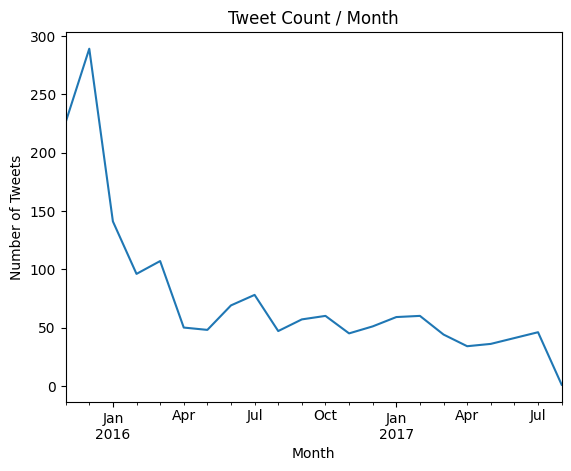

In [435]:
monthly_tweets_count.plot()
plt.title('Tweet Count / Month')
plt.xlabel('Month')
plt.ylabel('Number of Tweets');

The number of ratings that WeRateDogs has posted each month has decreased since the account was first started.

### Question 2: What is the monthly trend of interactions with WeRateDogs's posts?

Here I will define "interactions" as the sum of retweets and favorites. I will create a new column called `tweet_activity` with this sum, and then use a similar process as before to find the average `tweet_activity` per tweet by month.

In [436]:
archive_clean['tweet_activity'] = archive_clean['retweet_count']+archive_clean['favorite_count']

In [437]:
monthly_tweet_activity = archive_clean.groupby(archive_clean['timestamp'].dt.to_period('M'))['tweet_activity'].mean()

C:\Users\Nouma\AppData\Local\Temp\ipykernel_12216\2947328648.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_tweet_activity = archive_clean.groupby(archive_clean['timestamp'].dt.to_period('M'))['tweet_activity'].mean()


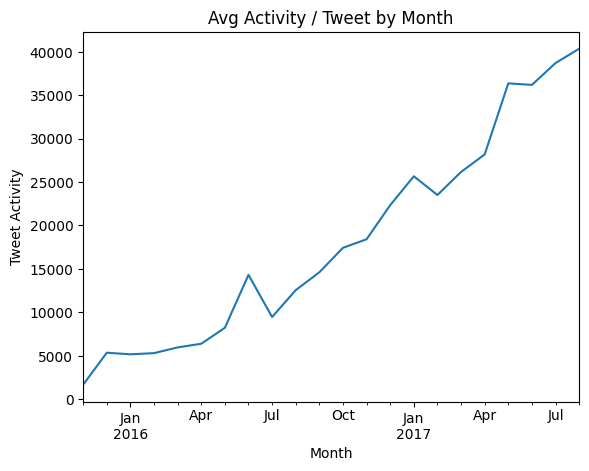

In [438]:
monthly_tweet_activity.plot()
plt.title('Avg Activity / Tweet by Month')
plt.xlabel('Month')
plt.ylabel('Tweet Activity');

The interaction with WeRateDogs's ratings has increased since the account was first started.

### Question 3: What are the most popular dog breeds based on number of posts, interactions by Twitter users, and ratings?

In order to identify the dog breed on each post, I will use the highest confidence prediction that is a dog. I will find the maximum for `predictions_clean` grouped by `tweet_id`, and then use an inner join to filter `predictions_clean` for only these maximum values.

In [439]:
best_dog_predictions = predictions_clean.query('dog_status == True')
best_dog_predictions = best_dog_predictions.groupby('tweet_id', as_index=False)['confidence'].max()

In [440]:
# use dataframe of maximum-confidence dog predictions to filter predictions_clean
best_dog_predictions = predictions_clean.merge(best_dog_predictions, how='inner', on=['tweet_id', 'confidence'])

In [442]:
# filter for breeds that have had at least 10 ratings
eligible_dogs = best_dog_predictions['prediction'].value_counts()
eligible_dogs = eligible_dogs[eligible_dogs >= 10].index

In [443]:
def calculate_by_breed(df, col):
    '''
    INPUT:
    df DataFrame
    col str
    
    OUTPUT:
    by_breed DataFrame
    '''
    
    new_df = df.merge(best_dog_predictions, how='inner', on='tweet_id')
    by_breed = new_df.groupby('prediction', as_index=False)[col].mean()
    by_breed = by_breed[by_breed['prediction'].isin(eligible_dogs)]
    return by_breed

In [444]:
activity_by_breed = calculate_by_breed(archive_cean, 'tweet_activity')

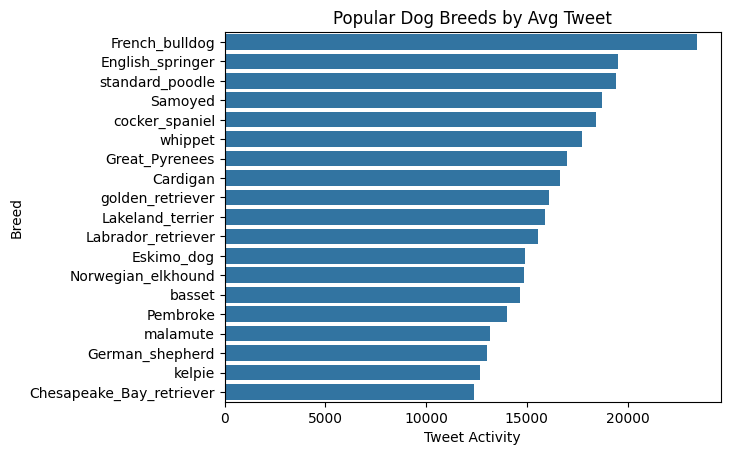

In [507]:
top_activity_by_breed = activity_by_breed.sort_values('tweet_activity', ascending=False).head(19)
sb.barplot(data=top_activity_by_breed, x='tweet_activity', y='prediction', color=base_color, )
plt.title('Popular Dog Breeds by Avg Tweet')
plt.xlabel('Tweet Activity')
plt.ylabel('Breed');

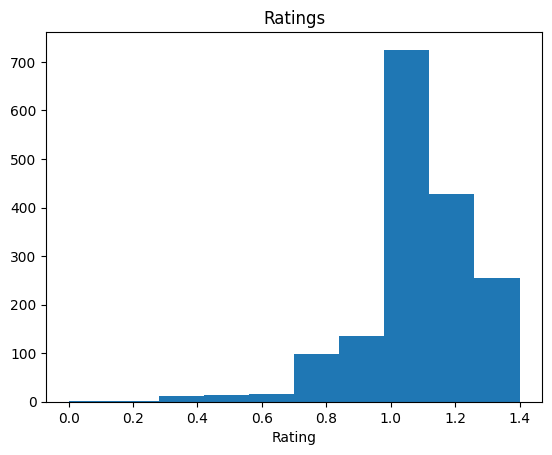

In [446]:
dogs_clean['rating'] = dogs_clean['rating_numerator']/dogs_clean['rating_denominator']
plt.hist(data=dogs_clean, x='rating')
plt.title('Ratings')
plt.xlabel('Rating');

In [447]:
ratings_by_breed = calculate_by_breed(dogs_clean, 'rating')

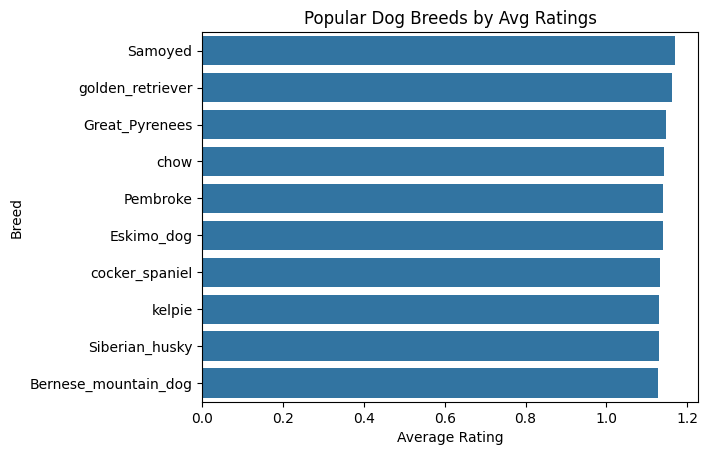

In [448]:
top_ratings_by_breed = ratings_by_breed.sort_values('rating', ascending=False).head(10)
sb.barplot(data=top_ratings_by_breed, x='rating', y='prediction', color=base_color)
plt.title('Popular Dog Breeds by Avg Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Breed');

There does not appear to be much difference between the top 10 dog breeds by average ratings. This is to be expected given that the ratings are pretty arbitrary. This brings me to the final question.

### Question 4: Is there any correlation between WeRateDogs's ratings and the interactions by Twitter users?

I will plot the average ratings against the average Twitter activity only for eligible breeds to see if there is any correlation.

In [506]:
ratings_activity_by_breed = ratings_by_breed.merge(activity_by_breed, how='outer', on='prediction')
plt.scatter(data=ratings_activity_by_breed, x='rating', y='tweet_activity')
plt.title('Avg Ratings vs. Tweet Activity ')
plt.xlabel('Rating')
plt.ylabel('Tweet Activity');

In [450]:
pearsonr(ratings_activity_by_breed['rating'], ratings_activity_by_breed['tweet_activity'])

PearsonRResult(statistic=np.float64(0.554158047547785), pvalue=np.float64(1.670076713581779e-05))

In [451]:
archive_dogs = archive_clean.merge(dogs_clean, how='inner', on='tweet_id')

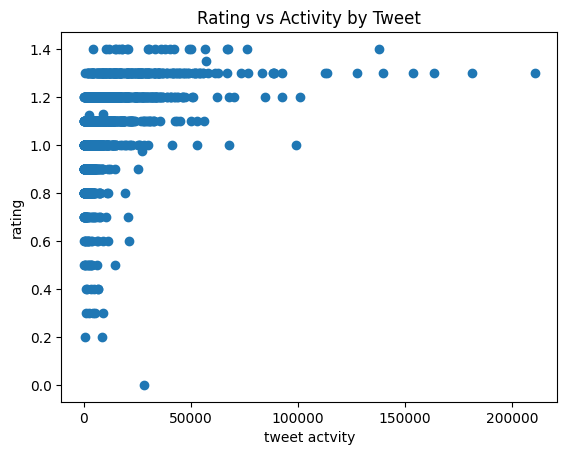

In [504]:
plt.scatter(data=archive_dogs, x='tweet_activity', y='rating')
plt.title('Rating vs Activity by Tweet')
plt.xlabel('tweet actvity')
plt.ylabel('rating');

In [453]:
archive_dogs_notnull = archive_dogs.dropna(subset=['tweet_activity'])

In [454]:
pearsonr(archive_dogs_notnull['rating'], archive_dogs_notnull['tweet_activity'])

PearsonRResult(statistic=np.float64(0.4071797612520949), pvalue=np.float64(2.683210538150836e-68))

In [455]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [456]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [457]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import mpl.pyplot as plt
import seaborn as sb
from scipy.stats import pearsonr
%mpl inline
pd.set_option('display.max_colwidth', None)

In [458]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
with open(url.split('/')[-1], mode='wb') as file:
    file.write(r.content)

In [459]:
predictions = pd.read_csv('image-predictions.tsv', sep='\t')

In [460]:
df_list = []
with open('tweet_json.txt', mode='r', encoding='utf-8') as file:
    lines = file.readlines()
    # Read tweet JSON data line by line
    for line in lines:
        try:
            data = json.loads(line)
            tweet_id = data.get('id', 'ID not found')  # Provide default if key is missing
            retweet_count = data.get('retweet_count', 0)  # Default to 0 if key is not found
            favorite_count = data.get('favorite_count', 0)  # Default to 0 if key is not found
            df_list.append({
                'tweet_id': tweet_id,
                'retweet_count': retweet_count,
                'favorite_count': favorite_count
            })
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

# Create DataFrame from list of dictionaries
tweet_data = pd.DataFrame(df_list, columns=['tweet_id', 'retweet_count', 'favorite_count'])

# Display the DataFrame
print(tweet_data.head())

             tweet_id  retweet_count  favorite_count
0  892420643555336193              0               0
1  892177421306343426              0               0
2  891815181378084864              0               0
3  891689557279858688              0               0
4  891327558926688256              0               0


In [461]:
archive

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892420643555336193                    NaN                  NaN   
1     892177421306343426                    NaN                  NaN   
2     891815181378084864                    NaN                  NaN   
3     891689557279858688                    NaN                  NaN   
4     891327558926688256                    NaN                  NaN   
...                  ...                    ...                  ...   
2351  666049248165822465                    NaN                  NaN   
2352  666044226329800704                    NaN                  NaN   
2353  666033412701032449                    NaN                  NaN   
2354  666029285002620928                    NaN                  NaN   
2355  666020888022790149                    NaN                  NaN   

                      timestamp  \
0     2017-08-01 16:23:56 +0000   
1     2017-08-01 00:17:27 +0000   
2     2017-07-31 00:18:03 +0000   
3     2017-07-30 15:58:51 +0000   
4     2017-07-29 16:00:24 +0000   
...                         ...   
2351  2015-11-16 00:24:50 +0000   
2352  2015-11-16 00:04:52 +0000   
2353  2015-11-15 23:21:54 +0000   
2354  2015-11-15 23:05:30 +0000   
2355  2015-11-15 22:32:08 +0000   

                                                                                  source  \
0     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
3     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
4     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
...                                                                                  ...   
2351  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2352  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2353  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2354  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2355  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                                                    text  \
0                                                          This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU   
1     This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV   
2                      This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB   
3                                                                This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ   
4     This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f   
...                                                                                                                                                                  ...   
2351                                            Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq   
2352                           This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx   
2353                                  Here is a very happy pup. Big fan of we

In [462]:
predictions

tweet_id                                          jpg_url  \
0     666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1     666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2     666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3     666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4     666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   
...                  ...                                              ...   
2070  891327558926688256  https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg   
2071  891689557279858688  https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg   
2072  891815181378084864  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg   
2073  892177421306343426  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg   
2074  892420643555336193  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg   

      img_num                      p1   p1_conf  p1_dog                  p2  \
0           1  Welsh_springer_spaniel  0.465074    True              collie   
1           1                 redbone  0.506826    True  miniature_pinscher   
2           1         German_shepherd  0.596461    True            malinois   
3           1     Rhodesian_ridgeback  0.408143    True             redbone   
4           1      miniature_pinscher  0.560311    True          Rottweiler   
...       ...                     ...       ...     ...                 ...   
2070        2                  basset  0.555712    True    English_springer   
2071        1             paper_towel  0.170278   False  Labrador_retriever   
2072        1               Chihuahua  0.716012    True            malamute   
2073        1               Chihuahua  0.323581    True            Pekinese   
2074        1                  orange  0.097049   False               bagel   

       p2_conf  p2_dog                           p3   p3_conf  p3_dog  
0     0.156665    True            Shetland_sheepdog  0.061428    True  
1     0.074192    True          Rhodesian_ridgeback  0.072010    True  
2     0.138584    True                   bloodhound  0.116197    True  
3     0.360687    True           miniature_pinscher  0.222752    True  
4     0.243682    True                     Doberman  0.154629    True  
...        ...     ...                          ...       ...     ...  
2070  0.225770    True  German_short-haired_pointer  0.175219    True  
2071  0.168086    True                      spatula  0.040836   False  
2072  0.078253    True                       kelpie  0.031379    True  
2073  0.090647    True                     papillon  0.068957    True  
2074  0.085851   False                       banana  0.076110   False  

[2075 rows x 12 columns]

In [463]:
tweet_data = pd.read_csv('tweet_json_clean.csv')

failed_tweet = []

with open('tweet_json.txt', mode='w', encoding='utf-8') as file:
    for index, row in tweet_data.iterrows():
        tweet_id = row['tweet_id']
        try:
            # Simulate or process tweet data (adjust based on your actual data structure)
            tweet = {
                'id': tweet_id,
                'created_at': row.get('created_at', ''),  # Replace with actual column name
                'full_text': row.get('full_text', '')
                # Add more fields as necessary
            }
            tweet_json = json.dumps(tweet)
            file.write(tweet_json + '\n')
        except Exception as e:
            print(f"Failed to process tweet {tweet_id}: {str(e)}")
            failed_tweet.append(tweet_id)

In [464]:
tweet_data

tweet_id  retweet_count  favorite_count  retweeted  \
0     892420643555336193           8853           39467      False   
1     892177421306343426           6514           33819      False   
2     891815181378084864           4328           25461      False   
3     891689557279858688           8964           42908      False   
4     891327558926688256           9774           41048      False   
...                  ...            ...             ...        ...   
2349  666049248165822465             41             111      False   
2350  666044226329800704            147             311      False   
2351  666033412701032449             47             128      False   
2352  666029285002620928             48             132      False   
2353  666020888022790149            532            2535      False   

     display_text_range  
0               [0, 85]  
1              [0, 138]  
2              [0, 121]  
3               [0, 79]  
4              [0, 138]  
...                 ...  
2349           [0, 120]  
2350           [0, 137]  
2351           [0, 130]  
2352           [0, 139]  
2353           [0, 131]  

[2354 rows x 5 columns]

In [465]:
sum(archive.duplicated())

0

In [466]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        1611 non-null   object 
 13  doggo                       97 no

In [467]:
len(archive[
    archive['retweeted_status_id'].notnull()
    & archive['retweeted_status_user_id'].notnull()
    & archive['retweeted_status_timestamp'].notnull()
])

181

In [468]:
archive['expanded_urls'].sample(5)

1948    https://twitter.com/dog_rates/status/673697980713705472/photo/1,https://twitter.com/dog_rates/status/673697980713705472/photo/1
1175                                                                    https://twitter.com/dog_rates/status/720043174954147842/photo/1
2109                                                                    https://twitter.com/dog_rates/status/670449342516494336/photo/1
499     https://twitter.com/dog_rates/status/813127251579564032/photo/1,https://twitter.com/dog_rates/status/813127251579564032/photo/1
2027    https://twitter.com/dog_rates/status/671874878652489728/photo/1,https://twitter.com/dog_rates/status/671874878652489728/photo/1
Name: expanded_urls, dtype: object

In [469]:
archive.describe()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
count  2.356000e+03           7.800000e+01         7.800000e+01   
mean   7.427716e+17           7.455079e+17         2.014171e+16   
std    6.856705e+16           7.582492e+16         1.252797e+17   
min    6.660209e+17           6.658147e+17         1.185634e+07   
25%    6.783989e+17           6.757419e+17         3.086374e+08   
50%    7.196279e+17           7.038708e+17         4.196984e+09   
75%    7.993373e+17           8.257804e+17         4.196984e+09   
max    8.924206e+17           8.862664e+17         8.405479e+17   

       retweeted_status_id  retweeted_status_user_id  rating_numerator  \
count         1.810000e+02              1.810000e+02       2356.000000   
mean          7.720400e+17              1.241698e+16         13.126486   
std           6.236928e+16              9.599254e+16         45.876648   
min           6.661041e+17              7.832140e+05          0.000000   
25%           7.186315e+17              4.196984e+09         10.000000   
50%           7.804657e+17              4.196984e+09         11.000000   
75%           8.203146e+17              4.196984e+09         12.000000   
max           8.874740e+17              7.874618e+17       1776.000000   

       rating_denominator  
count         2356.000000  
mean            10.455433  
std              6.745237  
min              0.000000  
25%             10.000000  
50%             10.000000  
75%             10.000000  
max            170.000000

In [470]:
archive['text'].str.extract('(\d+)/(\d+)').astype(int).describe()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Nouma\AppData\Local\Temp\ipykernel_12216\3622599330.py:1: SyntaxWarning: invalid escape sequence '\d'
  archive['text'].str.extract('(\d+)/(\d+)').astype(int).describe()


0            1
count  2356.000000  2356.000000
mean     13.126486    10.455433
std      45.876648     6.745237
min       0.000000     0.000000
25%      10.000000    10.000000
50%      11.000000    10.000000
75%      12.000000    10.000000
max    1776.000000   170.000000

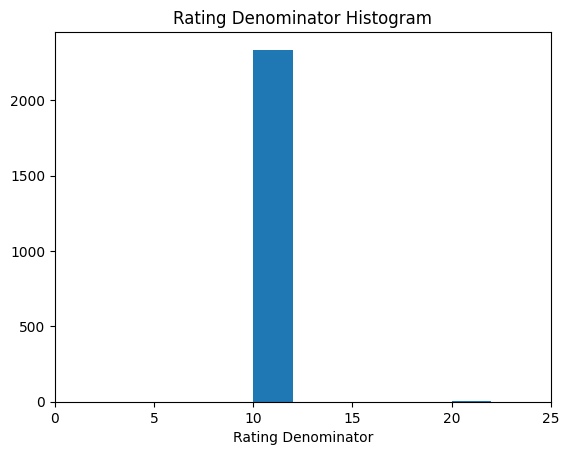

In [503]:
bins = np.arange(0, archive['rating_denominator'].max()+1, 2)
plt.hist(data=archive, x='rating_denominator', bins=bins)
plt.title('Rating Denominator Histogram')
plt.xlabel('Rating Denominator')
plt.xlim(0, 25);

In [472]:
archive.query('rating_denominator != 10')['text']

313                                                                            @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
342                                                                                                                                      @docmisterio account started on 11/15/15
433                                                                           The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
516     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
784                                  RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
902                                                                                                Why does th

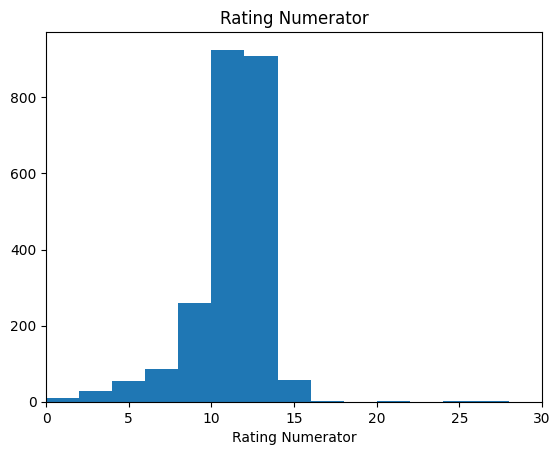

In [502]:
bins = np.arange(0, archive['rating_numerator'].max()+2, 2)
plt.hist(data=archive, x='rating_numerator', bins=bins)
plt.title('Rating Numerator')
plt.xlabel('Rating Numerator')
plt.xlim(0, 30);

In [474]:
archive.query('rating_numerator >= 15')['text']

55                                                                                    @roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s
188                                                                                        @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
189                                         @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10
285                                                                               RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI
290                                                                                                                                                            @markhoppus 182/10
291                                                                                                           

In [475]:
 with pd.option_context('display.max_rows', None):   
    print(archive.query('rating_numerator < 5')['text'])

315                                When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
605     RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…
765     This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M
883     This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP
912     Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL19Wsl
1004      Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R
1016                         PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 m

In [476]:
archive['name'].value_counts()

name
a             55
Charlie       12
Oliver        11
Cooper        11
Lucy          11
              ..
Aqua           1
Chase          1
Meatball       1
Rorie          1
Christoper     1
Name: count, Length: 956, dtype: int64

In [477]:
archive_cleaned = archive.dropna(subset=['name'])

# Use regex to find all lowercase names
lowercase_names = archive_cleaned[archive_cleaned['name'].str.contains(r'^[^A-Z].*$', na=False)]['name'].value_counts()

print(lowercase_names)

name
a               55
the              8
an               7
very             5
just             4
quite            4
one              4
getting          2
actually         2
mad              2
not              2
old              1
life             1
officially       1
light            1
by               1
infuriating      1
such             1
all              1
unacceptable     1
this             1
his              1
my               1
incredibly       1
space            1
Name: count, dtype: int64


In [478]:
archive_cleaned = archive.dropna(subset=['name'])

# Use regex to find all lowercase names
lowercase_names = archive_cleaned[archive_cleaned['name'].str.contains(r'^[^A-Z].*$', na=False)]['text']

# Print lowercase names and corresponding text
with pd.option_context('display.max_rows', None):
    print(lowercase_names)

22                                    I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba
56             Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
118                           RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…
169                   We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9
193     Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x
335                                                               There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10  

In [479]:
def compare_stage(stage, regex):
    '''
    INPUT:
    stage str
    regex str
    
    OUTPUT:
    
    Print value counts of original stage name extractions,
    '''
    
    print('Original value counts for {}:\n'.format(stage))
    print(archive[stage].value_counts())
    print('\n')
    print('New value counts:\n')
    stage_regex = archive['text'].str.extract(regex)[0]
    print(stage_regex.value_counts())
    print('\n')
    print('New total: {}'.format(stage_regex.count()))

In [480]:
compare_stage('doggo', '([Dd]+[Oo]+[Gg]+[Oo]+[Ss]*)')

Original value counts for doggo:

doggo
doggo    97
Name: count, dtype: int64


New value counts:

0
doggo     87
doggos    10
Doggo      9
DOGGO      1
Name: count, dtype: int64


New total: 107


In [481]:
compare_stage('floofer', '([Ff]+[Ll]+[Oo]+[Ff]+[Ee]+[Rr]+[Ss]*)')

Original value counts for floofer:

floofer
floofer    10
Name: count, dtype: int64


New value counts:

0
Floofer    6
floofer    4
Name: count, dtype: int64


New total: 10


In [482]:
compare_stage('pupper', '([Pp]+[Uu]+[Pp]+[Ee]+[Rr]+[Ss]*)')

Original value counts for pupper:

pupper
pupper    257
Name: count, dtype: int64


New value counts:

0
pupper     247
puppers     23
Pupper       8
PUPPER       5
Name: count, dtype: int64


New total: 283


In [483]:
compare_stage('puppo', '([Pp]+[Uu]+[Pp]+[Oo]+[Ss]*)')

Original value counts for puppo:

puppo
puppo    30
Name: count, dtype: int64


New value counts:

0
puppo     35
puppos     2
Puppo      1
Name: count, dtype: int64


New total: 38


In [484]:
sum(predictions.duplicated())

0

In [485]:
sum(predictions.duplicated('jpg_url'))

66

In [486]:
duplicated_jpg_url = predictions[predictions.duplicated('jpg_url')]['tweet_id']

In [487]:
archive.query('tweet_id in @duplicated_jpg_url')

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
19   888202515573088257                    NaN                  NaN   
36   885311592912609280                    NaN                  NaN   
95   873697596434513921                    NaN                  NaN   
155  861769973181624320                    NaN                  NaN   
211  851953902622658560                    NaN                  NaN   
..                  ...                    ...                  ...   
890  759566828574212096                    NaN                  NaN   
895  759159934323924993                    NaN                  NaN   
908  757729163776290825                    NaN                  NaN   
926  754874841593970688                    NaN                  NaN   
949  752309394570878976                    NaN                  NaN   

                     timestamp  \
19   2017-07-21 01:02:36 +0000   
36   2017-07-13 01:35:06 +0000   
95   2017-06-11 00:25:14 +0000   
155  2017-05-09 02:29:07 +0000   
211  2017-04-12 00:23:33 +0000   
..                         ...   
890  2016-07-31 01:50:18 +0000   
895  2016-07-29 22:53:27 +0000   
908  2016-07-26 00:08:05 +0000   
926  2016-07-18 03:06:01 +0000   
949  2016-07-11 01:11:51 +0000   

                                                                                 source  \
19   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
36   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
95   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
155  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
211  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
..                                                                                  ...   
890  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
895  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
908  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
926  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
949  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                           text  \
19   RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX   
36        RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5   
95    RT @dog_rates: This is Walter. He won't start hydrotherapy without his favorite floatie. 14/10 keep it pup Walter https://t.co/r28jFx9uyF   
155                RT @dog_rates: "Good afternoon class today we're going to learn what makes a good boy so good" 13/10 https://t.co/f1h2Fsalv9   
211                         RT @dog_rates: This is Astrid. She's a guide doggo in training. 13/10 would follow anywhere https://t.co/xo7FZFIAao   
..                                                                                                                                          ...   
890      RT @dog_rates: This... is a Tyrannosaurus rex. We only rate dogs. Please only send in dogs. Thank you ...10/10 https://t.co/zxw8d5g94P   
895                                                                         RT @dog_rates: AT DAWN...\nWE RIDE\n\n11/10 https://t.co/QnfO7HEQGA   
908                                                     RT @dog_rates: This is Chompsky. He lives up to his name. 11/10 https://t.co/Xl37lQEWd0   
926                                                           RT @dog_rates: This is Rubio. He has too much skin. 11/10 https://t.co/NLOHmlENag   
949                                        

In [488]:
archive.query('tweet_id in @duplicated_jpg_url')['retweeted_status_id'].count()

np.int64(66)

In [489]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [490]:
predictions.describe()

tweet_id      img_num      p1_conf       p2_conf       p3_conf
count  2.075000e+03  2075.000000  2075.000000  2.075000e+03  2.075000e+03
mean   7.384514e+17     1.203855     0.594548  1.345886e-01  6.032417e-02
std    6.785203e+16     0.561875     0.271174  1.006657e-01  5.090593e-02
min    6.660209e+17     1.000000     0.044333  1.011300e-08  1.740170e-10
25%    6.764835e+17     1.000000     0.364412  5.388625e-02  1.622240e-02
50%    7.119988e+17     1.000000     0.588230  1.181810e-01  4.944380e-02
75%    7.932034e+17     1.000000     0.843855  1.955655e-01  9.180755e-02
max    8.924206e+17     4.000000     1.000000  4.880140e-01  2.734190e-01

In [491]:
predictions.query('p1_conf+p2_conf+p3_conf > 1')

tweet_id                                          jpg_url  \
106  667866724293877760  https://pbs.twimg.com/media/CUS9PlUWwAANeAD.jpg   

     img_num             p1  p1_conf  p1_dog          p2       p2_conf  \
106        1  jigsaw_puzzle      1.0   False  prayer_rug  1.011300e-08   

     p2_dog       p3       p3_conf  p3_dog  
106   False  doormat  1.740170e-10   False

In [492]:
predictions.query('p1_dog == False & p2_dog == False & p3_dog == False')

tweet_id  \
6     666051853826850816   
17    666104133288665088   
18    666268910803644416   
21    666293911632134144   
25    666362758909284353   
...                  ...   
2021  880935762899988482   
2022  881268444196462592   
2046  886680336477933568   
2052  887517139158093824   
2074  892420643555336193   

                                                                                      jpg_url  \
6                                             https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg   
17                                            https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg   
18                                            https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg   
21                                            https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg   
25                                            https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg   
...                                                                                       ...   
2021                                          https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg   
2022                                          https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg   
2046                                          https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg   
2052  https://pbs.twimg.com/ext_tw_video_thumb/887517108413886465/pu/img/WanJKwssZj4VJvL9.jpg   
2074                                          https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg   

      img_num                p1   p1_conf  p1_dog               p2   p2_conf  \
6           1        box_turtle  0.933012   False       mud_turtle  0.045885   
17          1               hen  0.965932   False             cock  0.033919   
18          1  desktop_computer  0.086502   False             desk  0.085547   
21          1  three-toed_sloth  0.914671   False            otter  0.015250   
25          1        guinea_pig  0.996496   False            skunk  0.002402   
...       ...               ...       ...     ...              ...       ...   
2021        1       street_sign  0.251801   False         umbrella  0.115123   
2022        1            tusker  0.473303   False  Indian_elephant  0.245646   
2046        1       convertible  0.738995   False       sports_car  0.139952   
2052        1         limousine  0.130432   False        tow_truck  0.029175   
2074        1            orange  0.097049   False            bagel  0.085851   

      p2_dog              p3   p3_conf  p3_dog  
6      False        terrapin  0.017885   False  
17     False       partridge  0.000052   False  
18     False        bookcase  0.079480   False  
21     False  great_grey_owl  0.013207   False  
25     False         hamster  0.000461   False  
...      ...             ...       ...     ...  
2021   False   traffic_light  0.069534   False  
2022   False            ibex  0.055661   False  
2046   False       car_wheel  0.044173   False  
2052   False   shopping_cart  0.026321   False  
2074   False          banana  0.076110   False  

[324 rows x 12 columns]

In [493]:
predictions[predictions['p1'].str.contains(' ')]

Empty DataFrame
Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
Index: []

In [494]:
predictions[predictions['p2'].str.contains(' ')]

Empty DataFrame
Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
Index: []

In [495]:
predictions[predictions['p3'].str.contains(' ')]

Empty DataFrame
Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
Index: []

In [496]:
sum(tweet_data.duplicated())

0

In [497]:
sum(tweet_data.duplicated('tweet_id'))

0

In [498]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2354 non-null   int64 
 1   retweet_count       2354 non-null   int64 
 2   favorite_count      2354 non-null   int64 
 3   retweeted           2354 non-null   bool  
 4   display_text_range  2354 non-null   object
dtypes: bool(1), int64(3), object(1)
memory usage: 76.0+ KB


In [499]:
tweet_data.describe()

tweet_id  retweet_count  favorite_count
count  2.354000e+03    2354.000000     2354.000000
mean   7.426978e+17    3164.797366     8080.968564
std    6.852812e+16    5284.770364    11814.771334
min    6.660209e+17       0.000000        0.000000
25%    6.783975e+17     624.500000     1415.000000
50%    7.194596e+17    1473.500000     3603.500000
75%    7.993058e+17    3652.000000    10122.250000
max    8.924206e+17   79515.000000   132810.000000

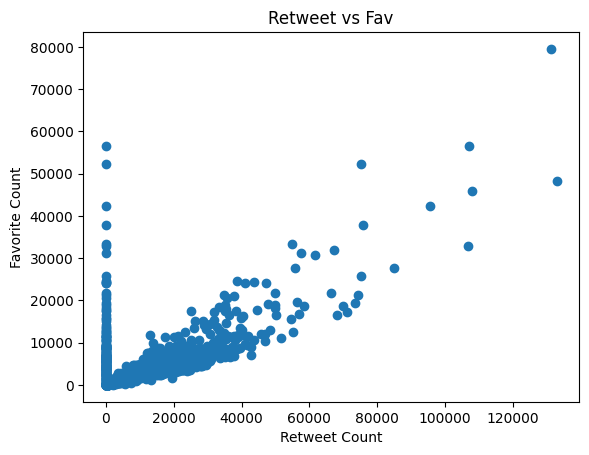

In [500]:
plt.scatter(data=tweet_data, x='favorite_count', y='retweet_count')
plt.title('Retweet vs Fav')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count');

In [ ]:
archive_dogs_notnull = archive_dogs.dropna(subset=['tweet_activity'])

In [ ]:
pearsonr(archive_dogs_notnull['rating'], archive_dogs_notnull['tweet_activity'])

(0.38489452432725135, 2.2380660269626426e-60)